Can I fit the RV data with the Joker?

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
from astropy.modeling import models, fitting
from astropy.timeseries import LombScargle
from astropy.visualization.units import quantity_support
import thejoker as tj
import astropy.table as at
from astropy.time import Time

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

/home/david/micromamba/envs/stenv/lib/python3.12/site-packages/arviz/__init__.py:39: FutureWarning: 
ArviZ is undergoing a major refactor to improve flexibility and extensibility while maintaining a user-friendly interface.
Some upcoming changes may be backward incompatible.
For details and migration guidance, visit: https://python.arviz.org/en/latest/user_guide/migration_guide.html
  warn(


In [4]:
rv_data = Table.read('dv_lists/bd_dvs.ecsv')


In [5]:
t = Time(rv_data['MJD'], format='mjd', scale='utc')
data = tj.RVData(t=t[4:], rv=rv_data['VELOCITY'][4:], rv_err=rv_data['ERROR'][4:])

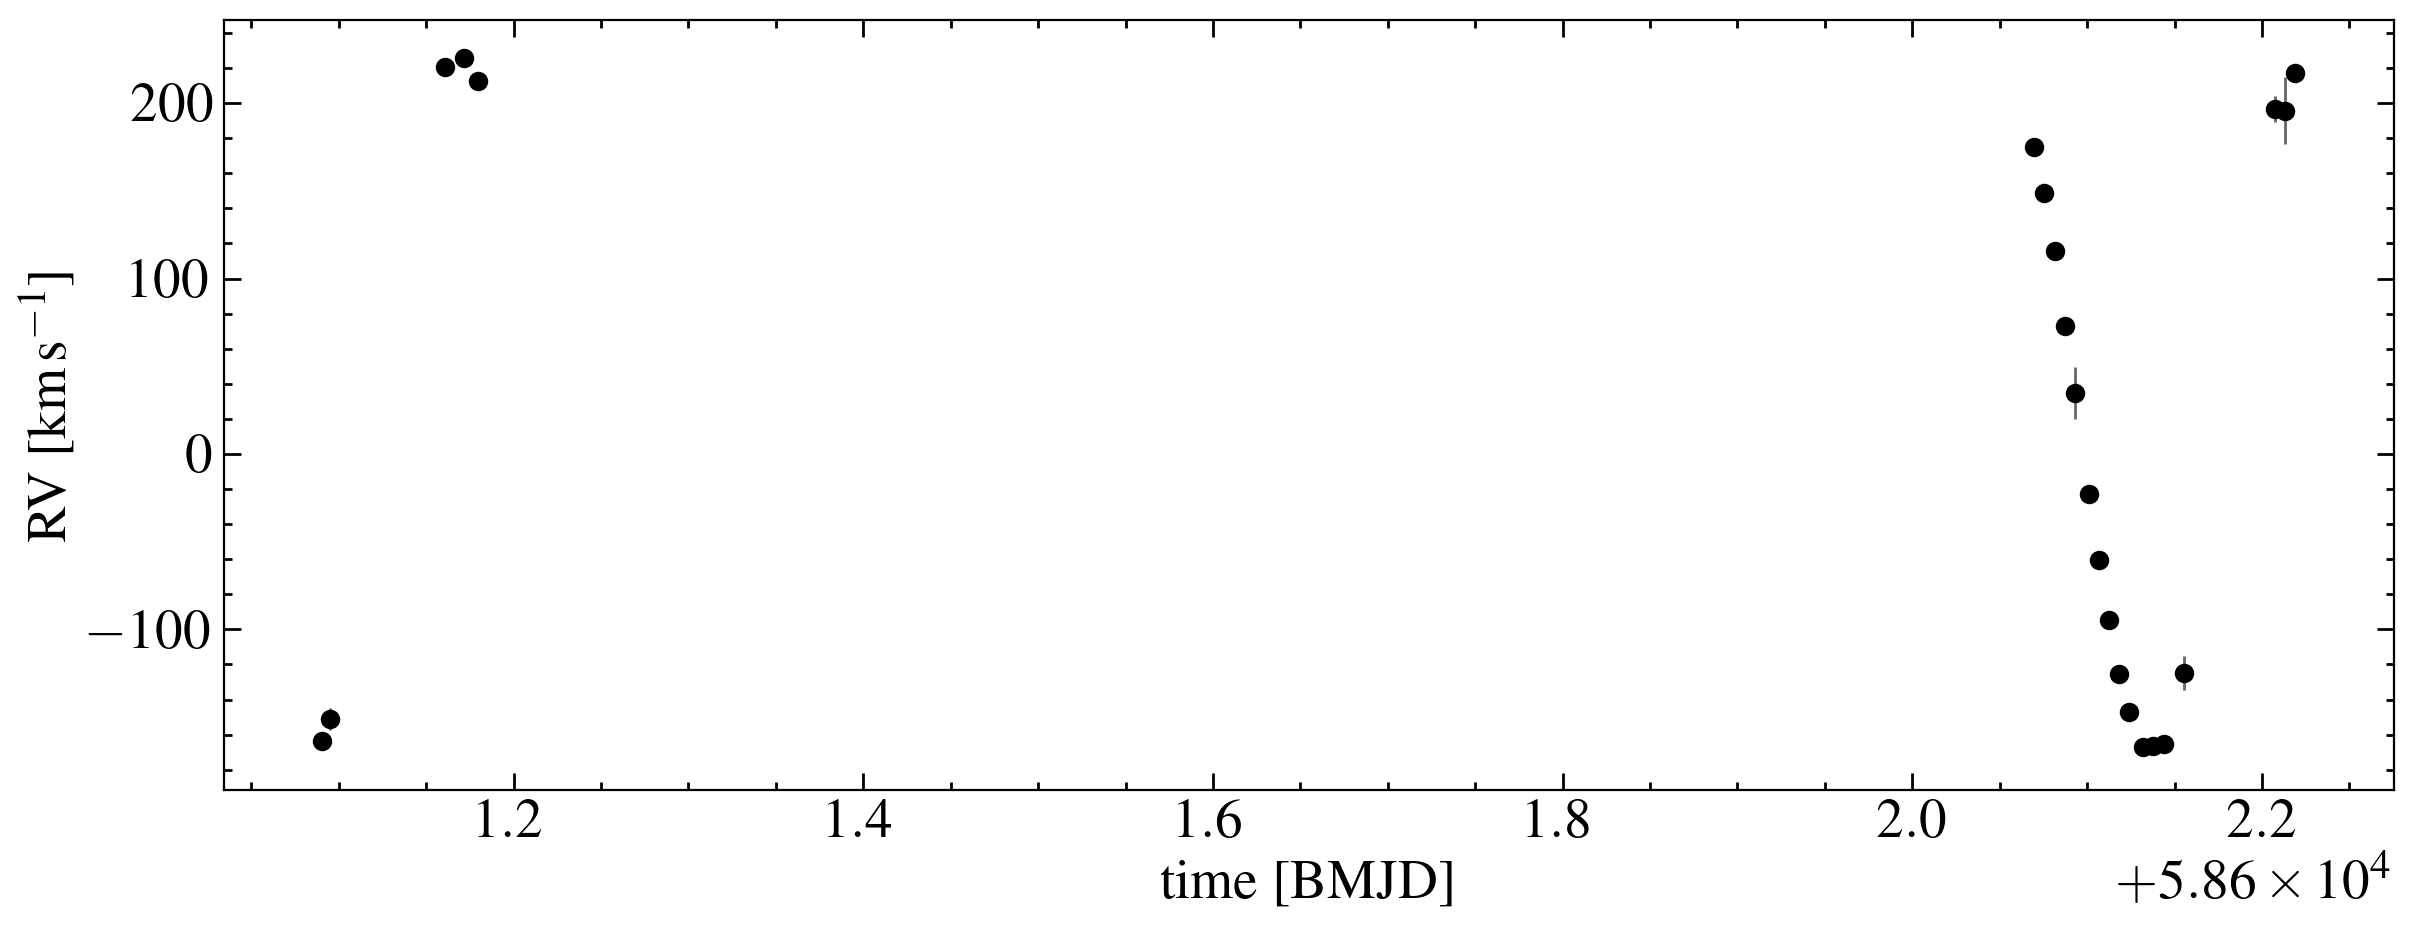

In [6]:
_ = data.plot()

In [7]:
rnd = np.random.default_rng(seed=42)

In [8]:
prior = tj.JokerPrior.default(
    P_min=3*u.hr, P_max=5*u.hr,
    sigma_K0=30*u.km/u.s,
    sigma_v=100*u.km/u.s)



/home/david/micromamba/envs/stenv/lib/python3.12/site-packages/pymc_ext/optim.py:4: FutureWarning: `pytensor.graph.basic.graph_inputs` was moved to `pytensor.graph.traversal.graph_inputs`. Calling it from the old location will fail in a future release.
  from pytensor.graph.basic import graph_inputs


In [10]:
prior_samples = prior.sample(size=1000_000,
                             random_state=rnd)
prior_samples


/tmp/ipykernel_220144/1480759576.py:1: DeprecationWarning: "random_state" was deprecated in version v1.3 and will be removed in a future version. Use argument "rng" instead.
  prior_samples = prior.sample(size=1000_000,


<JokerSamples [e, omega, M0, s, P] (1000000 samples)>

In [11]:
joker = tj.TheJoker(prior, random_state=rnd)
joker_samples = joker.rejection_sample(data, prior_samples,
                                       max_posterior_samples=100000)

/tmp/ipykernel_220144/1624329877.py:1: DeprecationWarning: "random_state" was deprecated in version v1.3 and will be removed in a future version. Use argument "rng" instead.
  joker = tj.TheJoker(prior, random_state=rnd)


In [12]:
joker_samples

<JokerSamples [P, e, omega, M0, s, K, v0] (2 samples)>

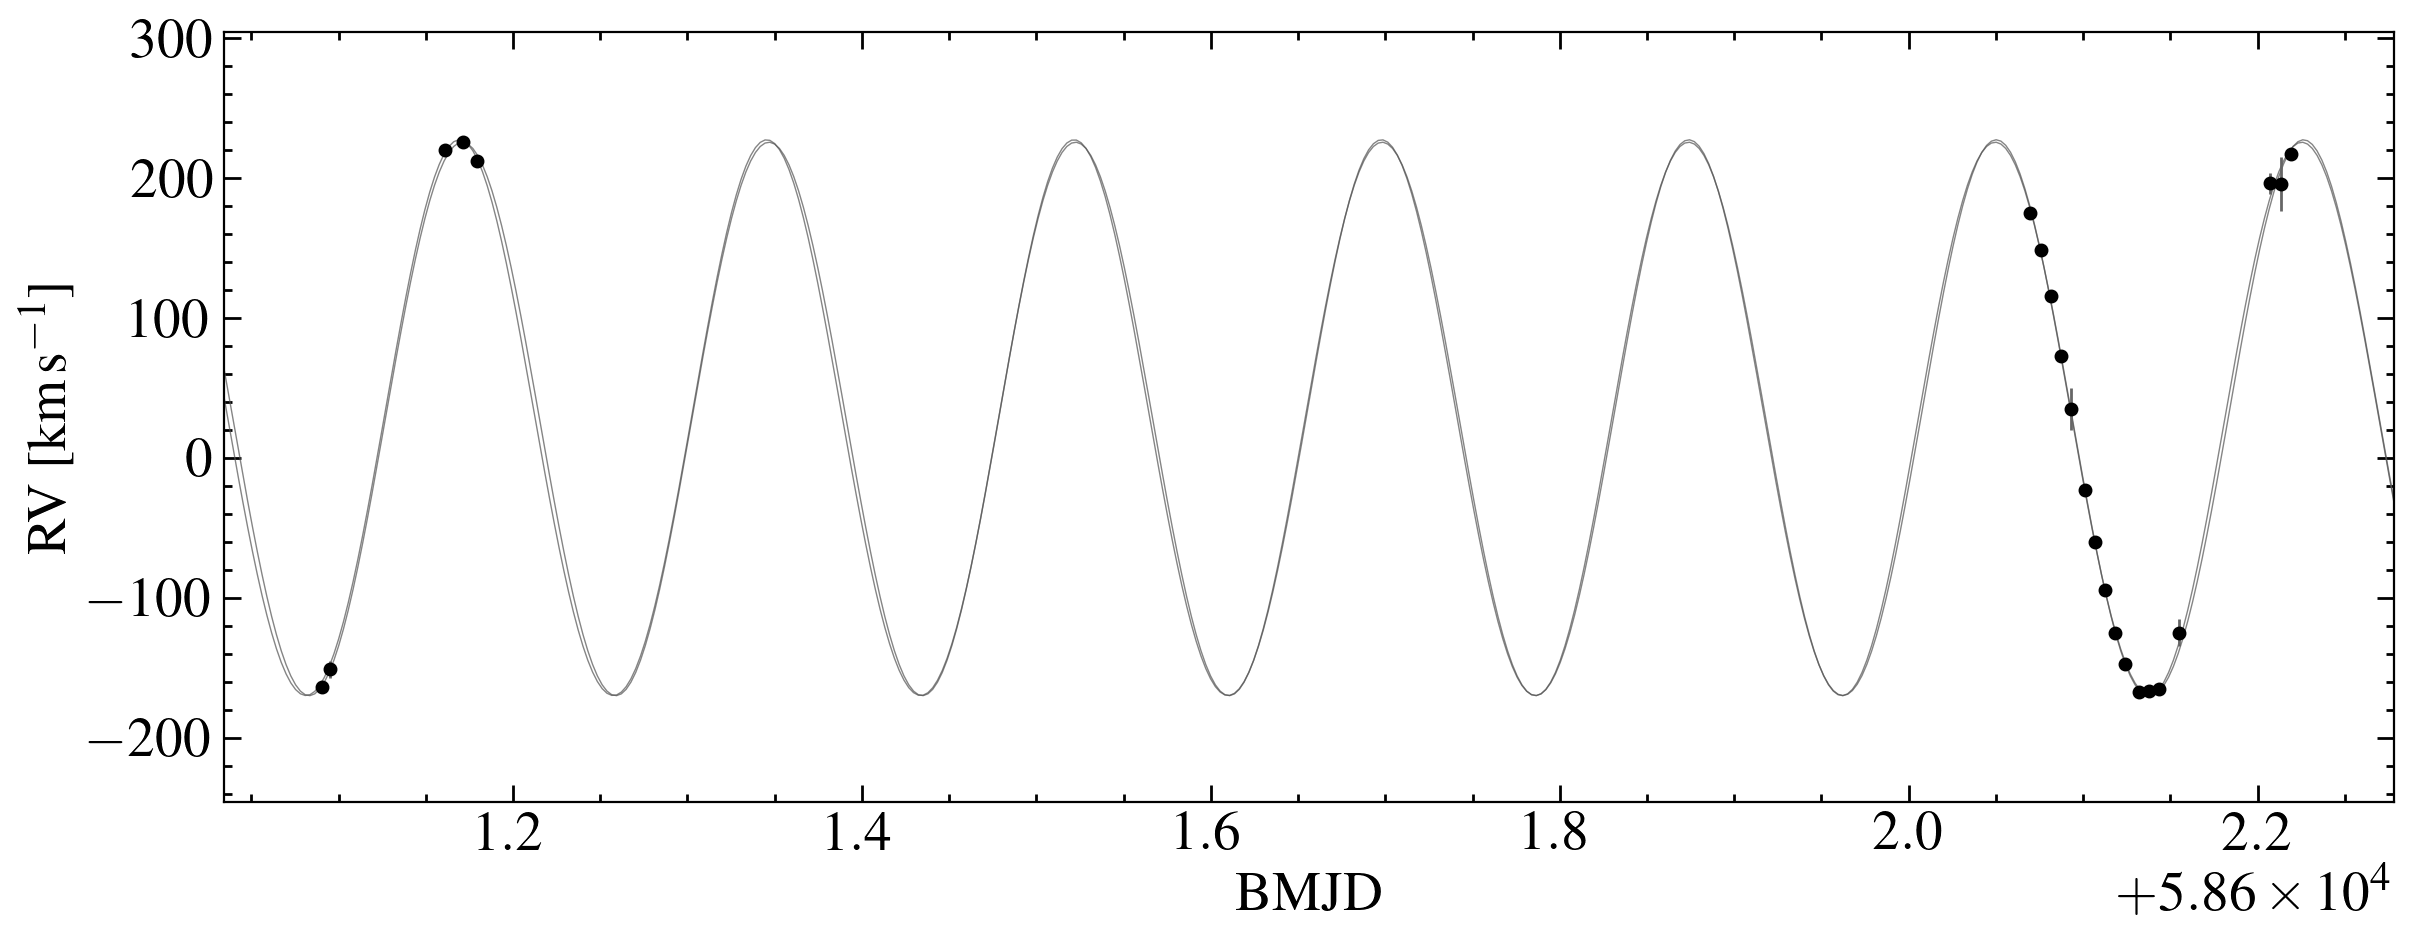

In [13]:
_ = tj.plot_rv_curves(joker_samples, data=data)

In [14]:
print(joker_samples['P'].to(u.hr))
print(joker_samples['omega'])
print(joker_samples['K'])
print(joker_samples['v0'])


[4.22835629 4.21765678] h
[-0.1185473  -2.99924442] rad
[198.71338316 197.88950421] km / s
[26.02143837 28.8910454 ] km / s


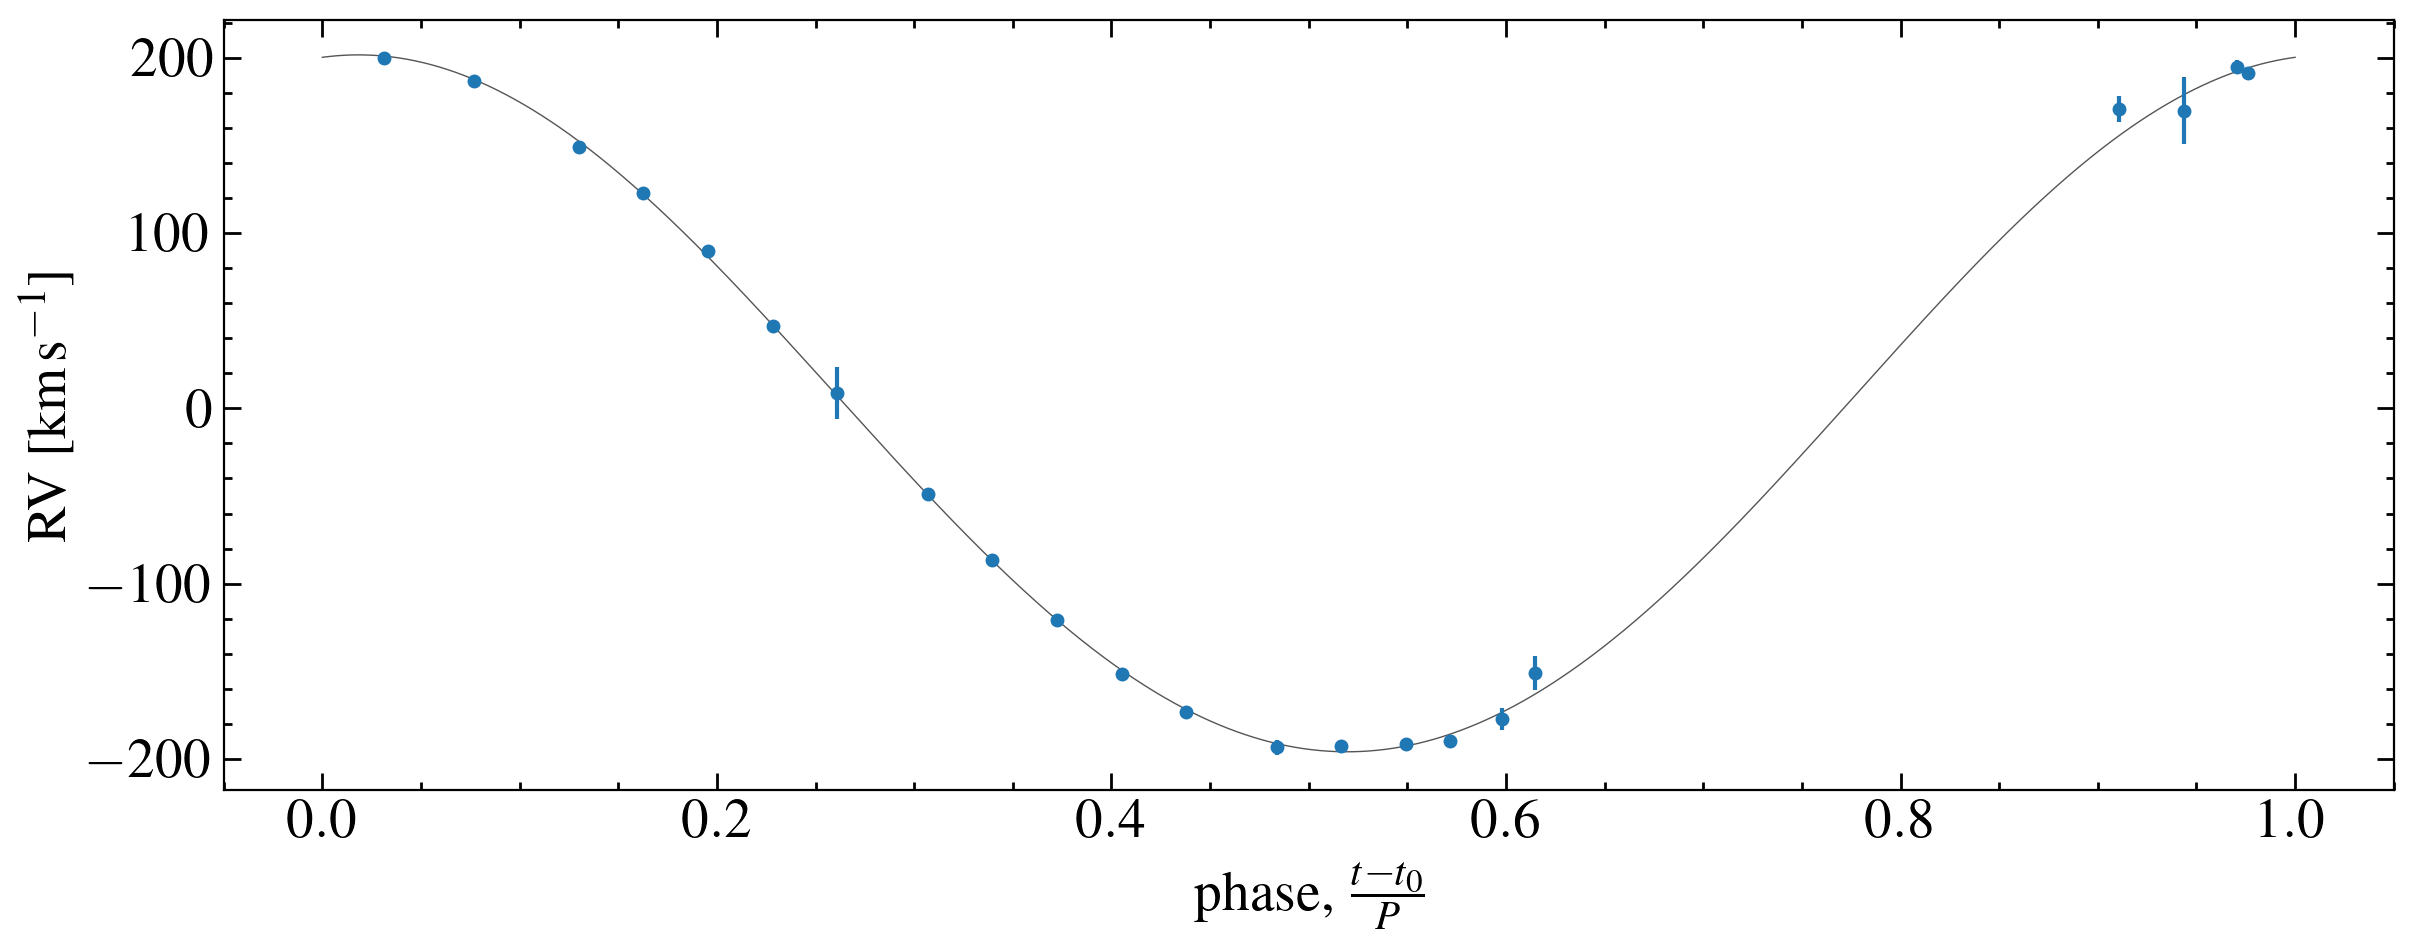

In [15]:
_ = tj.plot_phase_fold(joker_samples[0], data=data)

In [16]:
print(np.mean(joker_samples['P'].to(u.hr)),np.std(joker_samples['P'].to(u.hr)))

4.223006533037791 h 0.005349757749745443 h


joker not super good for well sampled data- limfit?

In [21]:
joker_samples

<JokerSamples [P, e, omega, M0, s, K, v0] (2 samples)>